In [23]:
%matplotlib inline

import pandas as pd
import datetime
from matplotlib import pyplot as plt


In [30]:
rain = pd.Series()
date = datetime.date(year = 2012, month = 1, day = 1)
while date < datetime.date(year = 2015, month = 1, day = 1):
    df = pd.read_json('data/weather/Theewaterskloof_{0}.json'.format(str(date.strftime('%Y%m%d'))))
    rain[date] = df['history']['dailysummary'][0]['precipm']
    date = date + datetime.timedelta(days = 1)
    

In [54]:
df = pd.read_json('data/weather/Theewaterskloof_20120101.json')
df = df['history']['dailysummary'][0]
df
new=pd.DataFrame()
new['d'] = df
new

,d
coolingdegreedays,date
coolingdegreedaysnormal,fog
date,rain
fog,snow
gdegreedays,snowfallm
hail,snowfalli
heatingdegreedays,monthtodatesnowfallm
heatingdegreedaysnormal,monthtodatesnowfalli
humidity,since1julsnowfallm
maxdewpti,since1julsnowfalli


In [41]:
rain = rain.astype(float)

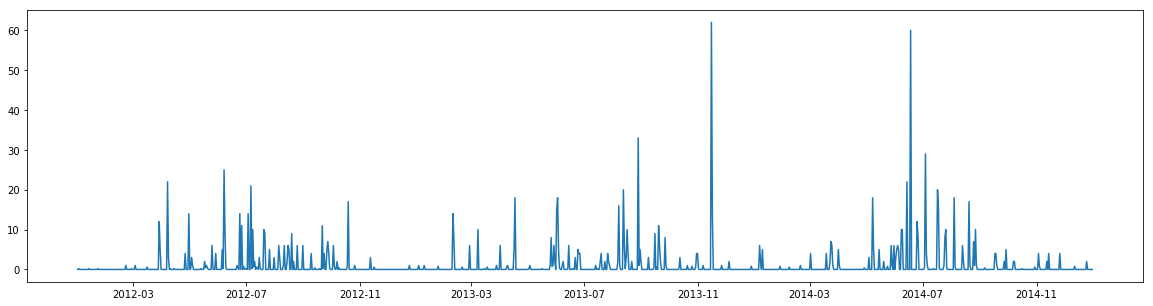

In [44]:
plt.figure(figsize = (20,5))
plt.plot(rain)

In [ ]:
weather_daysumm = pd.Series()
date = datetime.date(year = 2012, month = 1, day = 1)
while date < datetime.date(year = 2015, month = 1, day = 1):
    weather_json = pd.read_json('data/weather/Theewaterskloof_{0}.json'.format(str(date.strftime('%Y%m%d'))))
    weather_daysumm_json = weather_json['history']['dailysummary'][0]
    daysumm = pd.DataFrame()
    for key, value in weather_daysumm_json.items():
        print(key,value)
        if key != 'date':
            daysumm[key] = value
    print(daysumm)
    break
    weather_daysumm = pd.concat([weather_daysumm, daysumm])
    date = date + datetime.timedelta(days = 1)
    

In [ ]:
rain = pd.Series()
date = datetime.date(year = 2012, month = 1, day = 1)
while date < datetime.date(year = 2015, month = 1, day = 1):
    df = pd.read_json('data/weather/Theewaterskloof_{0}.json'.format(str(date.strftime('%Y%m%d'))))
    rain[date] = df['history']['dailysummary'][0]['precipm']
    date = date + datetime.timedelta(days = 1)
    
rain = rain.astype(float)

weather_daysumm

In [ ]:
rain = rain.reset_index()
rain.columns = ['date', 'precipm']
rain['date'] = pd.to_datetime(rain['date'])
rain.head()

In [ ]:
theewaterskloof = dam_levels.loc[(dam_levels['dam_name'] == 'Theewaterskloof')
                                 & (dam_levels['date'] < '2015-01-01')]

In [ ]:
theewaterskloof = pd.merge(theewaterskloof, rain, on = 'date')

In [ ]:
fig = plt.figure(figsize = (15,15) )
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

ax1.plot(theewaterskloof['diff_storage_ml'])
ax2.plot(theewaterskloof['precipm'])
ax3.plot(theewaterskloof['rolling3_lead1_precipm'])
#ax1.plot(theewaterskloof['precipm'])

In [ ]:
fig, ax = plt.subplots()
ax1, ax2 = two_scales(ax, theewaterskloof.index, theewaterskloof['storage_ml'], theewaterskloof['rolling3_lead1_precipm'], 'r', 'b')


In [ ]:
theewaterskloof['storage_ml'].corr(theewaterskloof['precipm'])
plt.scatter(theewaterskloof['storage_ml'],theewaterskloof['precipm'])
plt.ylim([0,20])

In [ ]:
theewaterskloof['diff_storage_ml'].corr(theewaterskloof['precipm'])
plt.figure(figsize = (10, 7))
plt.scatter(theewaterskloof['diff_storage_ml'],theewaterskloof['precipm'])

In [ ]:
theewaterskloof['diff_storage_ml'] = theewaterskloof['storage_ml'].diff(periods = 1)
theewaterskloof['lead1_precipm'] = theewaterskloof['precipm'].shift(periods = 1)
theewaterskloof['lead2_precipm'] = theewaterskloof['precipm'].shift(periods = 2)
theewaterskloof['lead3_precipm'] = theewaterskloof['precipm'].shift(periods = 3)
theewaterskloof['rolling2_lead1_precipm'] = theewaterskloof['lead1_precipm'].rolling(window = 2).sum()
theewaterskloof['rolling2_precipm'] = theewaterskloof['precipm'].rolling(window = 2).sum()


In [ ]:
theewaterskloof['diff_storage_ml'].corr(theewaterskloof['rolling2_lead1_precipm'])
plt.figure(figsize = (10, 7))
plt.scatter(theewaterskloof['diff_storage_ml'],theewaterskloof['rolling2_lead1_precipm'])

In [ ]:
theewaterskloof['month'] = theewaterskloof['date'].dt.month
theewaterskloof_winter = theewaterskloof.loc[(theewaterskloof['month'] >= 6) &
                                            (theewaterskloof['month'] < 10) &
                                            (theewaterskloof['diff_storage_ml'] > 0)]
theewaterskloof_winter['diff_storage_ml'].corr(theewaterskloof_winter['rolling2_lead1_precipm'])
plt.figure(figsize = (10, 7))
plt.scatter(theewaterskloof_winter['diff_storage_ml'],theewaterskloof_winter['rolling2_lead1_precipm'])

In [ ]:
theewaterskloof_winter['precipm'].hist(bins = 30)